In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Volkswagen.xlsx",sheet_name="Sheet1")

In [21]:
df2.drop(df2[df2["Fiyat"]>3000000].index, inplace=True)

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [22]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Bora,Seri_Golf,Seri_Jetta,...,Model_2.0 TDi Exclusive,Model_2.0 TDi Highline,Model_2.0 TFSi,Model_2.0 TSi R 4Motion,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,498900,0.090909,-0.333333,0.182692,-0.359551,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,728500,0.363636,0.083333,0.182692,0.329588,2.0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
2,337500,-1.000000,0.083333,0.168269,0.497978,NaN,NaN,0,1,0,...,0,0,0,0,0,0,1,1,0,0
3,810000,0.363636,0.500000,0.182692,0.764045,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,1364000,0.727273,1.333333,-0.298077,-1.093633,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [23]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [25]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [26]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [27]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_1532\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,80160.477642,5.514768e+09,74261.485342,49497.445925


In [28]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [29]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:49:32,161] A new study created in memory with name: no-name-af2eaf69-0cf3-4b16-80e2-b6faef94be00
[I 2023-05-23 21:49:32,405] Trial 0 finished with value: 664617.993678522 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.005395291395360742, 'max_depth': 14, 'min_child_weight': 205}. Best is trial 0 with value: 664617.993678522.
[I 2023-05-23 21:49:32,420] Trial 7 finished with value: 697509.6154986409 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.0001551310158608309, 'max_depth': 10, 'min_child_weight': 300}. Best is trial 0 with value: 664617.993678522.
[I 2023-05-23 21:49:32,470] Trial 2 finished with value: 688449.8844638108 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.001569083560501279, 'max_depth': 14, 'min_child_weight': 244}. Best is trial 0 with value: 664617.993678522.
[I 2023-05-23 21:49:32,490] Trial 1 finished with value: 195136.67534693974 and parameters: {'col

[I 2023-05-23 21:49:34,019] Trial 30 finished with value: 563478.8587243415 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.02286696158698139, 'max_depth': 6, 'min_child_weight': 62}. Best is trial 18 with value: 86962.7809636864.
[I 2023-05-23 21:49:34,026] Trial 32 finished with value: 545811.1062625326 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.026558063793967177, 'max_depth': 6, 'min_child_weight': 72}. Best is trial 18 with value: 86962.7809636864.
[I 2023-05-23 21:49:34,038] Trial 31 finished with value: 561367.6276695431 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.02326618173136772, 'max_depth': 6, 'min_child_weight': 62}. Best is trial 18 with value: 86962.7809636864.
[I 2023-05-23 21:49:34,111] Trial 33 finished with value: 554099.7910350378 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.024936244203686612, 'max_depth': 6, 'min_child_weight': 73

[I 2023-05-23 21:49:36,221] Trial 60 finished with value: 97856.53556374378 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.33354186391244023, 'max_depth': 3, 'min_child_weight': 23}. Best is trial 57 with value: 85385.44107544018.
[I 2023-05-23 21:49:36,317] Trial 61 finished with value: 108409.80930406449 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.4869846409231236, 'max_depth': 9, 'min_child_weight': 22}. Best is trial 57 with value: 85385.44107544018.
[I 2023-05-23 21:49:36,358] Trial 62 finished with value: 104641.05632804283 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3070376291041246, 'max_depth': 15, 'min_child_weight': 20}. Best is trial 57 with value: 85385.44107544018.
[I 2023-05-23 21:49:36,493] Trial 65 finished with value: 86608.18539626019 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3353650261115159, 'max_depth': 10, 'min_child_weight': 

[I 2023-05-23 21:49:38,255] Trial 90 finished with value: 84867.61452431392 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4949739685164558, 'max_depth': 12, 'min_child_weight': 27}. Best is trial 89 with value: 80517.50843141378.
[I 2023-05-23 21:49:38,361] Trial 91 finished with value: 120716.01522678454 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.25720831441945147, 'max_depth': 12, 'min_child_weight': 26}. Best is trial 89 with value: 80517.50843141378.
[I 2023-05-23 21:49:38,373] Trial 92 finished with value: 119305.5709225205 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.2654657825220052, 'max_depth': 12, 'min_child_weight': 26}. Best is trial 89 with value: 80517.50843141378.
[I 2023-05-23 21:49:38,427] Trial 93 finished with value: 115699.34170196472 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.2642190580266792, 'max_depth': 12, 'min_child_weight'

[I 2023-05-23 21:49:40,557] Trial 120 finished with value: 87566.38736584302 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4909709965032693, 'max_depth': 14, 'min_child_weight': 51}. Best is trial 89 with value: 80517.50843141378.
[I 2023-05-23 21:49:40,560] Trial 122 finished with value: 104432.79281137971 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.49825920851369704, 'max_depth': 14, 'min_child_weight': 50}. Best is trial 89 with value: 80517.50843141378.
[I 2023-05-23 21:49:40,609] Trial 121 finished with value: 93401.1264529592 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.305037579951766, 'max_depth': 14, 'min_child_weight': 50}. Best is trial 89 with value: 80517.50843141378.
[I 2023-05-23 21:49:40,676] Trial 123 finished with value: 89926.67439537775 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3502724965228122, 'max_depth': 14, 'min_child_weight

[I 2023-05-23 21:49:42,771] Trial 149 finished with value: 82970.57771445162 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4833585831611185, 'max_depth': 15, 'min_child_weight': 40}. Best is trial 89 with value: 80517.50843141378.
[I 2023-05-23 21:49:42,790] Trial 146 finished with value: 83457.59611668531 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.495933222163561, 'max_depth': 15, 'min_child_weight': 43}. Best is trial 89 with value: 80517.50843141378.
[I 2023-05-23 21:49:42,819] Trial 153 finished with value: 100100.52884132178 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.49658793107982757, 'max_depth': 14, 'min_child_weight': 154}. Best is trial 89 with value: 80517.50843141378.
[I 2023-05-23 21:49:42,866] Trial 152 finished with value: 83118.3939159187 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.47290669692249626, 'max_depth': 15, 'min_child_weig

[I 2023-05-23 21:49:45,079] Trial 180 finished with value: 87794.22276499795 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.42238234121901225, 'max_depth': 14, 'min_child_weight': 53}. Best is trial 89 with value: 80517.50843141378.
[I 2023-05-23 21:49:45,159] Trial 181 finished with value: 92342.13470165091 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.3261013575485487, 'max_depth': 11, 'min_child_weight': 57}. Best is trial 89 with value: 80517.50843141378.
[I 2023-05-23 21:49:45,345] Trial 182 finished with value: 86404.50063634689 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.32457629853206227, 'max_depth': 11, 'min_child_weight': 36}. Best is trial 89 with value: 80517.50843141378.
[I 2023-05-23 21:49:45,616] Trial 183 finished with value: 87586.07965012683 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.32273766210180416, 'max_depth': 14, 'min_child_wei

[I 2023-05-23 21:49:47,626] Trial 209 finished with value: 79475.38893784405 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.3820061791258374, 'max_depth': 15, 'min_child_weight': 6}. Best is trial 209 with value: 79475.38893784405.
[I 2023-05-23 21:49:47,747] Trial 211 finished with value: 85085.34438503593 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.3791474798989156, 'max_depth': 15, 'min_child_weight': 30}. Best is trial 209 with value: 79475.38893784405.
[I 2023-05-23 21:49:47,980] Trial 212 finished with value: 88207.38452331237 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.3732261470824343, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 209 with value: 79475.38893784405.
[I 2023-05-23 21:49:48,181] Trial 215 finished with value: 685790.3046570582 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.0019281644480484235, 'max_depth': 15, 'min_child_we

[I 2023-05-23 21:49:50,215] Trial 239 finished with value: 79698.51787646142 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.35257495931532706, 'max_depth': 15, 'min_child_weight': 7}. Best is trial 232 with value: 78744.86802242632.
[I 2023-05-23 21:49:50,603] Trial 241 finished with value: 81564.56558870693 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3397409774219164, 'max_depth': 15, 'min_child_weight': 6}. Best is trial 232 with value: 78744.86802242632.
[I 2023-05-23 21:49:50,875] Trial 242 finished with value: 83656.74069482782 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3439740455826623, 'max_depth': 15, 'min_child_weight': 9}. Best is trial 232 with value: 78744.86802242632.
[I 2023-05-23 21:49:51,044] Trial 244 finished with value: 80744.43365489997 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.34015540813850326, 'max_depth': 15, 'min_child_weig

In [30]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 78744.8680
Best params:
	colsample_bytree: 1.0
	subsample: 1.0
	learning_rate: 0.3525953454060323
	max_depth: 15
	min_child_weight: 9


In [31]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.3],
                  "max_depth": [13,15,17],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [1],
               'subsample': [1],
               'min_child_weight': [9]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
BEST PARAMS:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 9, 'n_estimators': 500, 'subsample': 1}
{'TestDeger': 80402.88226289525, 'MSE': 6828441471.000095, 'RMSE': 82634.38431427983, 'MAE': 52662.08725052521}


In [32]:
r2 = r2_score(y_test, y_pred)
r2

0.9284037696059956

In [33]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9201555769551123

In [35]:
marka_model = joblib.dump(grid_final_model, "Volkswagen.pkl")

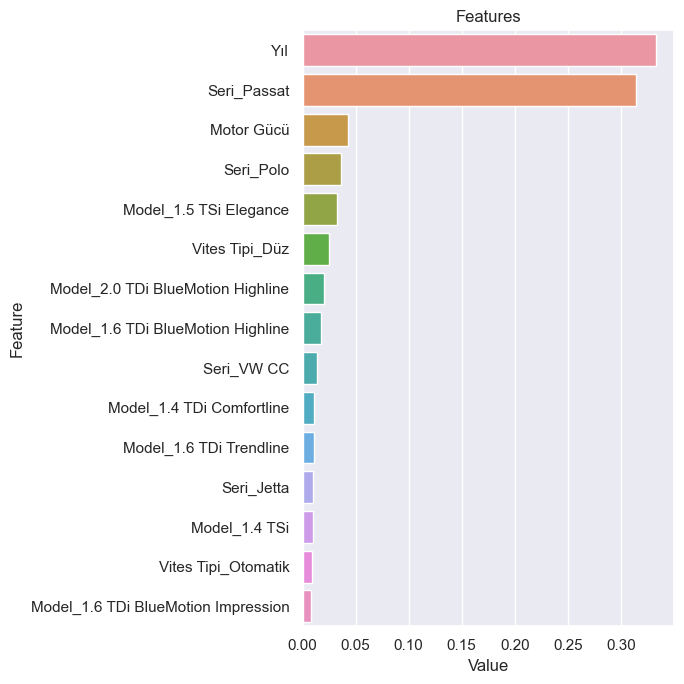

In [34]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)